In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
def feature_preprocessing(features):
    eps=1e-3
    to_log = [
           'LogicalCodeLines',
           'SourceCodeLines',
           #'Multilines',
           #'NumberOfFunctions',
           'CyclomaticComplexity',
           #'DistinctOperators',
           #'DistinctOperands',
           #'TotalOperators',
           #'TotalOperands',
           #'Vocabulary',
           #'LogicalLength',
           #'CalculatedLength',
           #'Volume',
           #'Difficulty',
           #'Effort',
           'NumberOfSnippets',
           'TotalCodeLines',
           'AvgSnippetCodeLines',
           'SphericalAvgL1Dist',
           'SphericalAvgL2Dist',
           'L2NormDirichletParamsL1Dist',
           'L2NormDirichletParamsL2Dist',
           'L2NormDirichletQAKLDiveregence',
           'L2NormDirichletAQKLDiveregence',
           'ArctanNormDirichletParamsL1Dist',
           'ArctanNormDirichletParamsL2Dist',
           'ArctanNormDirichletQAKLDiveregence',
           'ArctanNormDirichletAQKLDiveregence',
           'DiagNormQAKLDiveregence',
           'DiagNormAQKLDiveregence'
          ]
    to_inv_log = [
           'MaintainabilityIndexCodeLinesAvg',
           'MaintainabilityIndexUniformAvg',
           'AvgCosineSimilarity',
           'AvgL1NormCosineSimilarity',
           'AvgL2NormCosineSimilarity',
           #'SphericalAvgCosineSimilarity'
          ]
    to_id = [
           'MaintainabilityIndexCodeLinesAvg',
           'MaintainabilityIndexUniformAvg',
           'AvgCosineSimilarity',
           'AvgL1NormCosineSimilarity',
           'AvgL2NormCosineSimilarity',
           'SphericalAvgL1Dist',
           'L2NormDirichletParamsL1Dist',
           'L2NormDirichletQAKLDiveregence',
           'ArctanNormDirichletParamsL1Dist',
           'DiagNormQAKLDiveregence',
           'DiagNormAQKLDiveregence']
    return np.concatenate((
        np.log(np.clip(features[to_log].values, eps, np.inf)),
        np.log(1 - np.clip(features[to_inv_log].values,
            -np.inf,
            1-eps)),
        features[to_id].values
    ), axis=(len(features.shape) > 1) + 0)

def prepare_dataset(data, score_absolute_threshold, score_percent_threshold, scaler, preprocessing_f):
    data = data[
            np.abs(data.AnswerScore_first - data.AnswerScore_second) >\
                np.max(
                    np.stack((
                    [score_absolute_threshold] * data.shape[0],
                    score_percent_threshold
                    * np.max(
                        np.stack((
                            np.abs(data.AnswerScore_first.values),
                            np.abs(data.AnswerScore_second.values)),
                            axis=1),
                        axis=1)),
                    axis=1),
                axis=1)
            ]
    return list(zip(
            torch.from_numpy(
                np.clip(
                    scaler.transform(
                        preprocessing_f(
                            data[[_ + "_first" for _ in columns]].rename(
                                lambda column: column.removesuffix("_first"),
                                axis='columns')
                        ).astype(np.float32)
                    ),
                -3, 3)
            ).to(device),
            torch.from_numpy(
                np.clip(
                    scaler.transform(
                        preprocessing_f(
                            data[[_ + "_second" for _ in columns]].rename(
                                lambda column: column.removesuffix("_second"),
                                axis='columns')
                        ).astype(np.float32)
                    ),
                -3, 3)
            ).to(device),
            torch.from_numpy(
                ((data.AnswerScore_first > data.AnswerScore_second) * 2 - 1.0).values.astype(np.float32)
            ).to(device)
        ))

In [ ]:
columns = ['LogicalCodeLines',
           'SourceCodeLines',
           'Multilines',
           'NumberOfFunctions',
           'CyclomaticComplexity',
           'DistinctOperators',
           'DistinctOperands',
           'TotalOperators',
           'TotalOperands',
           'Vocabulary',
           'LogicalLength',
           'CalculatedLength',
           'Volume',
           'Difficulty',
           'Effort',
           'NumberOfSnippets',
           'TotalCodeLines',
           'AvgSnippetCodeLines',
           'MaintainabilityIndexCodeLinesAvg',
           'MaintainabilityIndexUniformAvg',
           'AvgCosineSimilarity',
           'AvgL1NormCosineSimilarity',
           'AvgL2NormCosineSimilarity',
           'SphericalAvgL1Dist',
           'SphericalAvgL2Dist',
           'SphericalAvgCosineSimilarity',
           'L2NormDirichletParamsL1Dist',
           'L2NormDirichletParamsL2Dist',
           'L2NormDirichletQAKLDiveregence',
           'L2NormDirichletAQKLDiveregence',
           'ArctanNormDirichletParamsL1Dist',
           'ArctanNormDirichletParamsL2Dist',
           'ArctanNormDirichletQAKLDiveregence',
           'ArctanNormDirichletAQKLDiveregence',
           'DiagNormQAKLDiveregence',
           'DiagNormAQKLDiveregence']
ds = pd.read_csv("/content/dataset.csv")
ds.dropna(inplace=True)
ds = ds[ds.groupby("QuestionId").transform("count").AnswerId > 1]
ds.set_index(ds.AnswerId, inplace=True)

In [ ]:
train_idx, test_idx= train_test_split(ds.QuestionId.unique(),
                                        test_size=0.1,
                                        random_state=42,
                                        shuffle=True)
std_scaler = StandardScaler()
std_scaler.fit(feature_preprocessing(ds[ds.QuestionId.isin(train_idx)][columns]))

StandardScaler()

In [ ]:
import joblib
joblib.dump(std_scaler, "std_scaler")

['std_scaler']

In [ ]:
train_score_absolute_threshold = 10
test_score_absolute_threshold = 10
train_score_percent_threshold = 0.15
test_score_percent_threshold = 0.15

train_data = pd.merge(
                ds[ds.QuestionId.isin(train_idx)],
                ds[ds.QuestionId.isin(train_idx)],
                how="inner",
                suffixes=("_first", "_second"),
                left_on="QuestionId",
                right_on="QuestionId")
train_data = prepare_dataset(
                train_data,
                train_score_absolute_threshold,
                train_score_percent_threshold,
                std_scaler,
                feature_preprocessing)

test_data = pd.merge(
                    ds[ds.QuestionId.isin(test_idx)],
                    ds[ds.QuestionId.isin(test_idx)],
                    how="inner",
                    suffixes=("_first", "_second"),
                    left_on="QuestionId",
                    right_on="QuestionId")
test_data = prepare_dataset(
                test_data,
                test_score_absolute_threshold,
                test_score_percent_threshold,
                std_scaler,
                feature_preprocessing)

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_params, hidden_state_size=15):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_params, hidden_state_size),
            nn.GELU(),
            nn.Linear(hidden_state_size, hidden_state_size),
            nn.GELU(),
            nn.Linear(hidden_state_size, hidden_state_size),
            nn.GELU(),
            nn.Linear(hidden_state_size, hidden_state_size),
            nn.GELU(),
            nn.Linear(hidden_state_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


class AttentionModel(nn.Module):
    def __init__(self, n_params, hidden_state_size=15):
        super().__init__()
        self.first_attn_layer = nn.TransformerEncoderLayer(d_model=n_params,
                                                           nhead=1,
                                                           dim_feedforward=1,
                                                           batch_first=True)
        self.second_attn_layer = nn.TransformerEncoderLayer(d_model=n_params,
                                                           nhead=1,
                                                           dim_feedforward=1,
                                                           batch_first=True)
        self.linear = nn.Linear(n_params, 1)

    def forward(self, x):
        first_attn_output = self.first_attn_layer(x)
        second_attn_output = self.second_attn_layer(first_attn_output + x)
        third_attn_output = self.second_attn_layer(second_attn_output + first_attn_output)
        return nn.Sigmoid()(self.linear(third_attn_output))


class RankNet(nn.Module):
    def __init__(self, num_feature):
        super(RankNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, input):
        return self.model.forward(input)

    def predict(self, input_):
        s = self.model(input_)
        return s

In [ ]:
def train(dataloader, model, loss_fn, optimizer, train_loss_hist, train_accuracy_hist, verbose):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    correct = 0
    for batch, (ans1, ans2, sign) in enumerate(dataloader):
        pred1 = model(ans1).squeeze()
        pred2 = model(ans2).squeeze()
        loss = loss_fn(pred1, pred2, sign)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        correct += ((pred1 > pred2) ^ (sign < 0)).type(torch.int).sum().item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(ans1)
            if verbose:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss_hist.append(train_loss / len(dataloader))
    train_accuracy_hist.append(correct / size)

def test(dataloader, model, loss_fn, test_loss_hist, test_accuracy_hist, verbose):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for ans1, ans2, sign in dataloader:
            pred1 = model(ans1).squeeze()
            pred2 = model(ans2).squeeze()
            test_loss += loss_fn(pred1, pred2, sign).item()
            correct += ((pred1 > pred2) ^ (sign < 0)).type(torch.int).sum().item()
    test_loss /= num_batches
    correct /= size
    test_loss_hist.append(test_loss)
    test_accuracy_hist.append(correct)
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

def rank_train(dataloader, model, loss_fn, optimizer, train_loss_hist, train_accuracy_hist, verbose):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    correct = 0
    for batch, (ans1, ans2, sign) in enumerate(dataloader):
        pred1 = model(ans1).squeeze()
        pred2 = model(ans2).squeeze()
        pred = nn.Sigmoid()(pred1 - pred2)
        loss = loss_fn(pred, (sign + 1.0) / 2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
        correct += ((pred > 0.5) ^ (sign < 0)).type(torch.int).sum().item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(ans1)
            if verbose:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss_hist.append(train_loss / len(dataloader))
    train_accuracy_hist.append(correct / size)

def rank_test(dataloader, model, loss_fn, test_loss_hist, test_accuracy_hist, verbose):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for ans1, ans2, sign in dataloader:
            pred1 = model(ans1).squeeze()
            pred2 = model(ans2).squeeze()
            pred = nn.Sigmoid()(pred1 - pred2)
            test_loss += loss_fn(pred, (sign + 1.0) / 2).item()
            correct += ((pred > 0.5) ^ (sign < 0)).type(torch.int).sum().item()
    test_loss /= num_batches
    correct /= size
    test_loss_hist.append(test_loss)
    test_accuracy_hist.append(correct)
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

def test_model_performance(
            model_class,
            input_size,
            device,
            loss_fn,
            optimizer,
            epochs,
            train_data,
            test_data,
            verbose=True,
            batch_size=200,
            torch_seed=42
                ):
    torch.manual_seed(torch_seed)
    model = model_class(input_size).to(device)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_loss_hist, train_accuracy_hist, test_loss_hist, test_accuracy_hist = [], [], [], []
    optimizer = optimizer(model.parameters())
    if type(model) == RankNet:
        train_fn, test_fn = rank_train, rank_test
    else:
        train_fn, test_fn = train, test
    for epoch in range(epochs):
        if verbose:
            print(f"Epoch {epoch+1}\n-------------------------------")
        train_fn(train_dataloader, model, loss_fn, optimizer, train_loss_hist, train_accuracy_hist, verbose)
        test_fn(test_dataloader, model, loss_fn, test_loss_hist, test_accuracy_hist, verbose)
    if verbose:
        print("Done!")
    return test_accuracy_hist #train_loss_hist, train_accuracy_hist, test_loss_hist

In [ ]:
torch.manual_seed(42)
ranknet_model = RankNet(34).to(device)
train_dataloader = DataLoader(train_data, batch_size=200, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=200, shuffle=True)
train_loss_hist, train_accuracy_hist, test_loss_hist, test_accuracy_hist = [], [], [], []
optimizer = torch.optim.Adam(ranknet_model.parameters())
for epoch in range(28):
    print(f"Epoch {epoch+1}\n-------------------------------")
    rank_train(train_dataloader, ranknet_model, nn.BCELoss(), optimizer, train_loss_hist, train_accuracy_hist, verbose=True)
    rank_test(test_dataloader, ranknet_model, nn.BCELoss(), test_loss_hist, test_accuracy_hist, verbose=True)

Epoch 1
-------------------------------
loss: 0.703461  [  200/80364]
loss: 0.647436  [20200/80364]
loss: 0.619315  [40200/80364]
loss: 0.656686  [60200/80364]
loss: 0.616141  [80200/80364]
Test Error: 
 Accuracy: 64.5%, Avg loss: 0.634675 

Epoch 2
-------------------------------
loss: 0.606507  [  200/80364]
loss: 0.639200  [20200/80364]
loss: 0.577611  [40200/80364]
loss: 0.641410  [60200/80364]
loss: 0.542677  [80200/80364]
Test Error: 
 Accuracy: 63.5%, Avg loss: 0.640596 

Epoch 3
-------------------------------
loss: 0.639444  [  200/80364]
loss: 0.590884  [20200/80364]
loss: 0.640108  [40200/80364]
loss: 0.611160  [60200/80364]
loss: 0.615770  [80200/80364]
Test Error: 
 Accuracy: 65.1%, Avg loss: 0.634288 

Epoch 4
-------------------------------
loss: 0.675001  [  200/80364]
loss: 0.644039  [20200/80364]
loss: 0.658260  [40200/80364]
loss: 0.663929  [60200/80364]
loss: 0.617203  [80200/80364]
Test Error: 
 Accuracy: 64.9%, Avg loss: 0.632717 

Epoch 5
------------------------

In [ ]:
torch.save(ranknet_model.state_dict(), "/content/ranknet_estimator.pt")

In [ ]:
accuracy = test_model_performance(
    model_class = RankNet,
    input_size = train_data[0][0].size(0),
    device = device,
    loss_fn = nn.BCELoss(),
    optimizer = torch.optim.Adam,
    epochs = 40,
    train_data = train_data,
    test_data = test_data,
    verbose=True
)

Epoch 1
-------------------------------
loss: 0.702484  [  200/66992]
loss: 0.605462  [20200/66992]
loss: 0.584537  [40200/66992]
loss: 0.637526  [60200/66992]
Test Error: 
 Accuracy: 64.4%, Avg loss: 0.634052 

Epoch 2
-------------------------------
loss: 0.626343  [  200/66992]
loss: 0.655938  [20200/66992]
loss: 0.570761  [40200/66992]
loss: 0.615626  [60200/66992]
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.629646 

Epoch 3
-------------------------------
loss: 0.633543  [  200/66992]
loss: 0.661103  [20200/66992]
loss: 0.601955  [40200/66992]
loss: 0.593447  [60200/66992]
Test Error: 
 Accuracy: 65.4%, Avg loss: 0.624918 

Epoch 4
-------------------------------
loss: 0.622350  [  200/66992]
loss: 0.561164  [20200/66992]
loss: 0.556090  [40200/66992]
loss: 0.643549  [60200/66992]
Test Error: 
 Accuracy: 64.5%, Avg loss: 0.628303 

Epoch 5
-------------------------------
loss: 0.633103  [  200/66992]
loss: 0.554983  [20200/66992]
loss: 0.598832  [40200/66992]
loss: 0.653109  [60200

In [ ]:
np.max(accuracy), np.argmax(accuracy)+1

(0.6474252491694352, 3)

In [ ]:
metrics_of_margin = {
    "mlp_best_epoch": [],
    "mlp_accuracy": [],
    "attention_best_epoch": [],
    "attention_accuracy": [],
}

In [ ]:
for margin in range(0, 101, 5):
    test_accuracy = test_model_performance(
                                model_class = MLP,
                                input_size = train_data[0][0].size(0),
                                device = device,
                                loss_fn = nn.MarginRankingLoss(margin / 100),
                                optimizer = torch.optim.Adam,
                                epochs = 40,
                                train_data = train_data,
                                test_data = test_data,
                                verbose=False
                    )
    metrics_of_margin["mlp_accuracy"].append(np.max(test_accuracy))
    metrics_of_margin["mlp_best_epoch"].append(np.argmax(test_accuracy)+1)
    print(f"MLP with margin {margin / 100} done!")

MLP with margin 0.0 done!
MLP with margin 0.05 done!
MLP with margin 0.1 done!
MLP with margin 0.15 done!
MLP with margin 0.2 done!
MLP with margin 0.25 done!
MLP with margin 0.3 done!
MLP with margin 0.35 done!
MLP with margin 0.4 done!
MLP with margin 0.45 done!
MLP with margin 0.5 done!
MLP with margin 0.55 done!
MLP with margin 0.6 done!
MLP with margin 0.65 done!
MLP with margin 0.7 done!
MLP with margin 0.75 done!
MLP with margin 0.8 done!
MLP with margin 0.85 done!
MLP with margin 0.9 done!
MLP with margin 0.95 done!
MLP with margin 1.0 done!


In [ ]:
metrics_of_margin

{'mlp_best_epoch': [31,
  9,
  9,
  9,
  5,
  5,
  6,
  5,
  8,
  7,
  6,
  6,
  7,
  8,
  8,
  5,
  17,
  8,
  6,
  17,
  3],
 'mlp_accuracy': [0.5951837480027391,
  0.6438027847523397,
  0.6454005934718101,
  0.6454005934718101,
  0.6442593015293312,
  0.6438027847523397,
  0.6483679525222552,
  0.6474549189682721,
  0.6460853686372974,
  0.6458571102488017,
  0.6447158183063227,
  0.6440310431408355,
  0.644487559917827,
  0.6428897511983566,
  0.6435745263638438,
  0.6417484592558776,
  0.6388952293996805,
  0.6451723350833143,
  0.6419767176443735,
  0.6377539374572015,
  0.6289659895001142],
 'attention_best_epoch': [1,
  7,
  17,
  21,
  34,
  37,
  5,
  5,
  5,
  3,
  3,
  3,
  7,
  7,
  7,
  31,
  36,
  38,
  15,
  36,
  2],
 'attention_accuracy': [0.5979228486646885,
  0.6483679525222552,
  0.6466560146085368,
  0.6456288518603058,
  0.6475690481625199,
  0.6430038803926045,
  0.6443734307235791,
  0.6447158183063227,
  0.6447158183063227,
  0.6482538233280073,
  0.6469984021

In [ ]:
for margin in range(0, 101, 5):
    test_accuracy = test_model_performance(
                                model_class = AttentionModel,
                                input_size = train_data[0][0].size(0),
                                device = device,
                                loss_fn = nn.MarginRankingLoss(margin / 100),
                                optimizer = torch.optim.Adam,
                                epochs = 40,
                                train_data = train_data,
                                test_data = test_data,
                                verbose=False
                    )
    metrics_of_margin["attention_accuracy"].append(np.max(test_accuracy))
    metrics_of_margin["attention_best_epoch"].append(np.argmax(test_accuracy)+1)
    print(f"Attention with margin {margin / 100} done!")

Attention with margin 0.0 done!
Attention with margin 0.05 done!
Attention with margin 0.1 done!
Attention with margin 0.15 done!
Attention with margin 0.2 done!
Attention with margin 0.25 done!
Attention with margin 0.3 done!
Attention with margin 0.35 done!
Attention with margin 0.4 done!
Attention with margin 0.45 done!
Attention with margin 0.5 done!
Attention with margin 0.55 done!
Attention with margin 0.6 done!
Attention with margin 0.65 done!
Attention with margin 0.7 done!
Attention with margin 0.75 done!
Attention with margin 0.8 done!
Attention with margin 0.85 done!
Attention with margin 0.9 done!
Attention with margin 0.95 done!
Attention with margin 1.0 done!


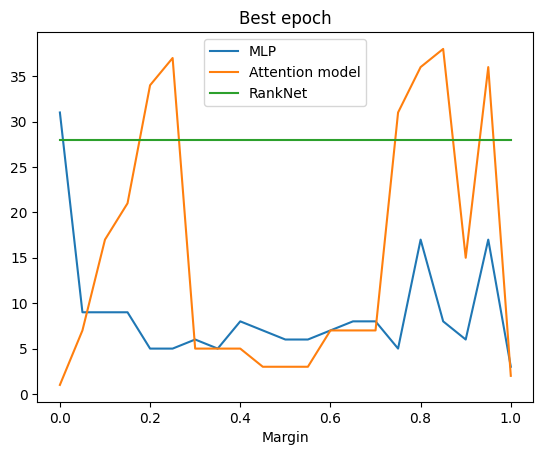

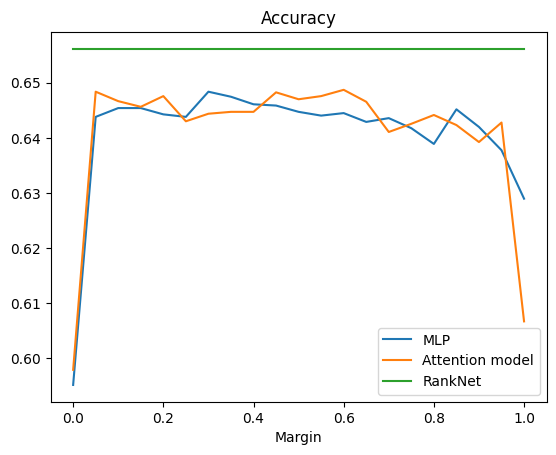

In [ ]:
plt.plot(np.asarray(range(0, 101, 5)) / 100, metrics_of_margin["mlp_best_epoch"], label="MLP")
plt.plot(np.asarray(range(0, 101, 5)) / 100, metrics_of_margin["attention_best_epoch"], label="Attention model")
plt.plot(np.asarray(range(0, 101, 5)) / 100, [28] * 21, label="RankNet")
plt.legend()
plt.xlabel("Margin")
plt.title("Best epoch")
plt.savefig("best_epoch.png")
plt.show()

plt.plot(np.asarray(range(0, 101, 5)) / 100, metrics_of_margin["mlp_accuracy"], label="MLP")
plt.plot(np.asarray(range(0, 101, 5)) / 100, metrics_of_margin["attention_accuracy"], label="Attention model")
plt.plot(np.asarray(range(0, 101, 5)) / 100, [0.6561287377311116] * 21, label="RankNet")
plt.legend()
plt.xlabel("Margin")
plt.title("Accuracy")
plt.savefig("acc.png")
plt.show()

In [ ]:
torch.manual_seed(42)
final_estimator = RankNet(num_feature=34).to(device)
loss_fn = nn.BCEWithLogitsLoss() # nn.BCELoss() epoch 21 accuracy 65.1
optimizer = torch.optim.AdamW(final_estimator.parameters()) # torch.optim.Adam(final_estimator.parameters())
train_dataloader = DataLoader(train_ds, batch_size=200, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=200, shuffle=True)
train_loss_hist, train_accuracy_hist, test_loss_hist, test_accuracy_hist = [], [], [], []

In [ ]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    rank_train(train_dataloader, final_estimator, loss_fn, optimizer, train_loss_hist, train_accuracy_hist)
    rank_test(test_dataloader, final_estimator, loss_fn, test_loss_hist, test_accuracy_hist)
print("Done!")

In [ ]:
plt.plot(range(100), train_loss_hist, label="Train loss")
plt.plot(range(100), test_loss_hist, label="Test loss")
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss")
#plt.savefig("Ranknet_loss.png")
plt.show()

plt.plot(range(100), train_accuracy_hist, label="Train accuracy")
plt.plot(range(100), test_accuracy_hist, label="Test accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.title("Accuracy")
#plt.savefig("Ranknet_acc.png")
plt.show()